In [1]:
# !pip install cufflinks
import pandas as pd
from openpyxl import load_workbook
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
import copy
import plotly.io as pio
pio.renderers.default = "iframe"
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler,PowerTransformer
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
np.set_printoptions(suppress = True)

from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix









# 讀取資料集

In [2]:
df = pd.read_excel("heart.xlsx", engine = "openpyxl")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# 查看各欄位的資料型態

In [3]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

# 將object的資料型態改成string

In [4]:
object_column = df.select_dtypes(include="object").columns
df[object_column] = df[object_column].astype("string")
df_copy = copy.deepcopy(df)

df.dtypes

Age                        int64
Sex               string[python]
ChestPainType     string[python]
RestingBP                  int64
Cholesterol                int64
FastingBS                  int64
RestingECG        string[python]
MaxHR                      int64
ExerciseAngina    string[python]
Oldpeak                  float64
ST_Slope          string[python]
HeartDisease               int64
dtype: object

# 針對數值型欄位進行統計分析

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


#  探索式數據分析
##### 理解資料集，並發現其中的模式、趨勢、異常值、相關性等。

# 將特徵拆分出數值型與類別型

In [6]:
all_features = list(df.columns)

categorical_features = df.select_dtypes("string").columns.to_list()
categorical_features.insert(2,"FastingBS")
categorical_features.append("HeartDisease")

numerical_features = [x for x in all_features if x not in categorical_features]

print(f"categorical_features: {categorical_features} \n")
print(f"numerical_features: {numerical_features} ")


categorical_features: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease'] 

numerical_features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'] 


# 將類別型特徵的值轉成數字標籤

In [7]:
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])
df["ChestPainType"] = le.fit_transform(df["ChestPainType"])
df["RestingECG"] = le.fit_transform(df["RestingECG"])
df["ExerciseAngina"] = le.fit_transform(df["ExerciseAngina"])
df["ST_Slope"] = le.fit_transform(df["ST_Slope"])
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


# 檢查數值型特徵的分佈

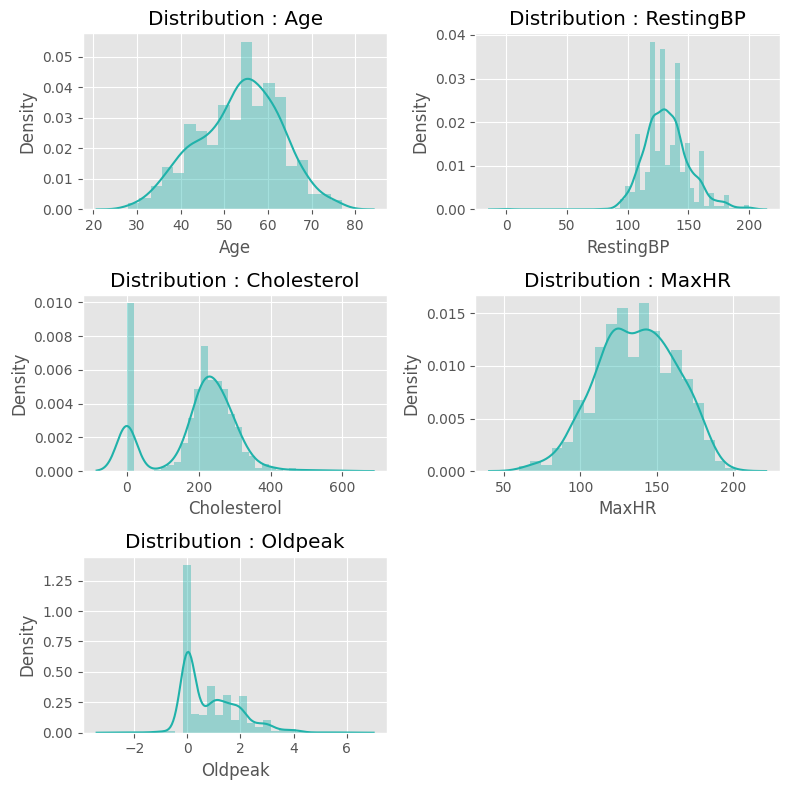

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (8,8))
axes = axes.flatten()


for i in range(len(numerical_features)):
    sns.distplot(df[numerical_features[i]], ax = axes[i], color = "lightseagreen")
    title = "Distribution : " + numerical_features[i]
    axes[i].set_title(title)

axes[-1].axis('off')


plt.tight_layout()
plt.show()

# 類別型特徵的資料分佈

Text(0.5, 1.0, 'Distribution : HeartDisease')

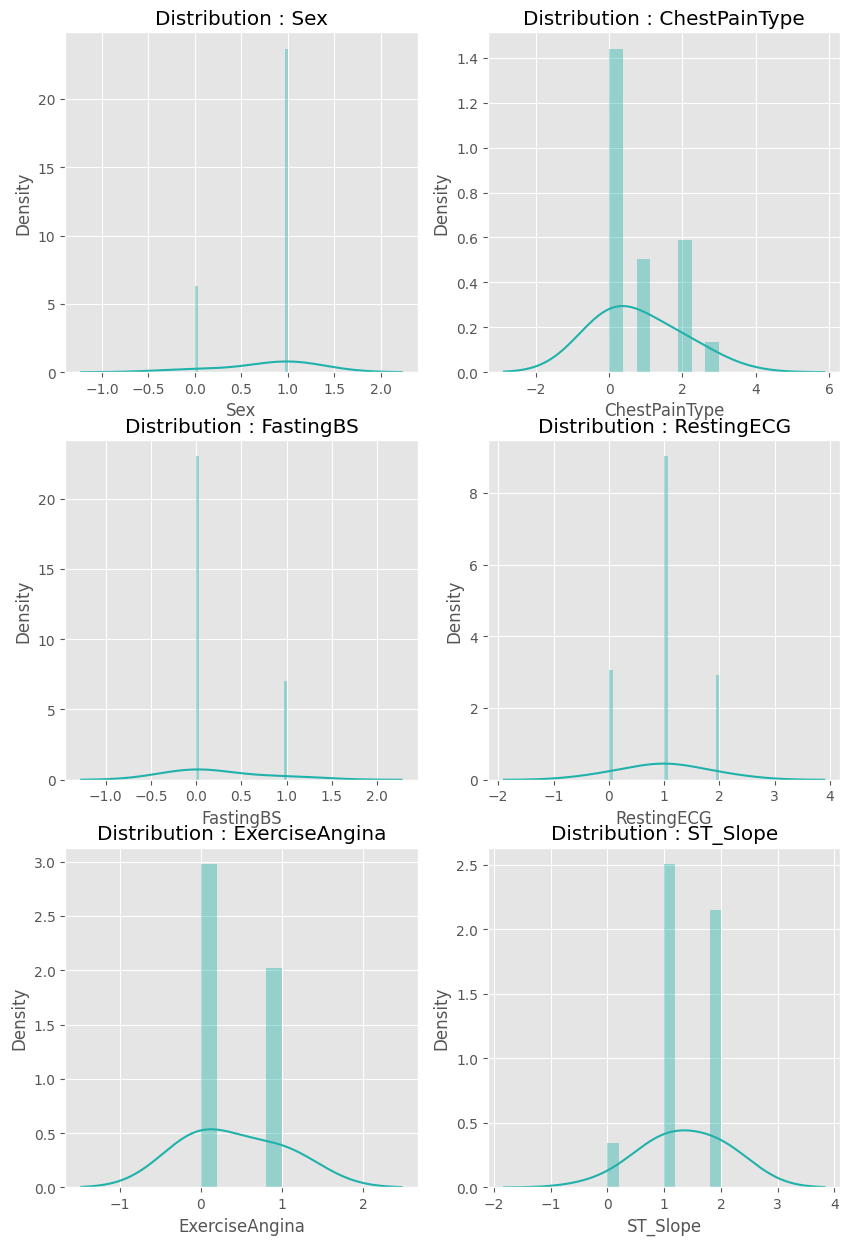

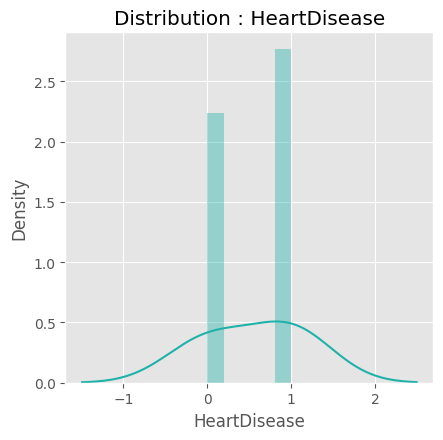

In [23]:
fig, ax = plt.subplots(nrows = 3, ncols = 2,figsize = (10,15))
ax = ax.flatten()


for i in range(len(categorical_features) -1):
    sns.distplot(df[categorical_features[i]], ax = ax[i], color = "lightseagreen", kde_kws = {'bw':1},)
    title = "Distribution : " + categorical_features[i]
    ax[i].set_title(title)

plt.figure(figsize = (4.75, 4.55))
sns.distplot(df["HeartDisease"], kde_kws = {'bw':1}, color ="lightseagreen")
title = "Distribution : HeartDisease"
plt.title(title)

# 查看資料集是否平衡

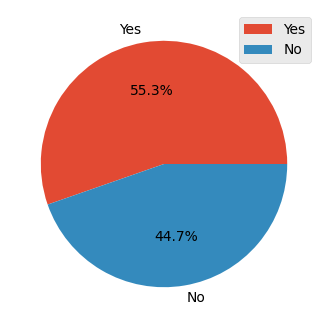

In [10]:
target_counts = df['HeartDisease'].value_counts() #Serires

target_counts_df = pd.DataFrame(target_counts).reset_index()
target_counts_df.columns = ['HeartDisease', 'Count']

target_counts_df.iloc[0,0] = "Yes"
target_counts_df.iloc[1,0] = "No"

labels = target_counts_df.HeartDisease
values = target_counts_df.Count

plt.figure(figsize=(4, 4))

plt.pie(values, labels = labels, autopct='%1.1f%%')

plt.legend(labels, loc='best')  

plt.show()


# 相關矩陣
#### 當有多個變數之間高度相關時，可能產生多重共線性的問題，其會影響模型的準確性和穩定性，特別是回歸模型。
#### 當兩個或多個自變數高度相關時，回歸模型沒有辦法單獨解釋這些變數的具體貢獻，導致模型無法做出準確預測。

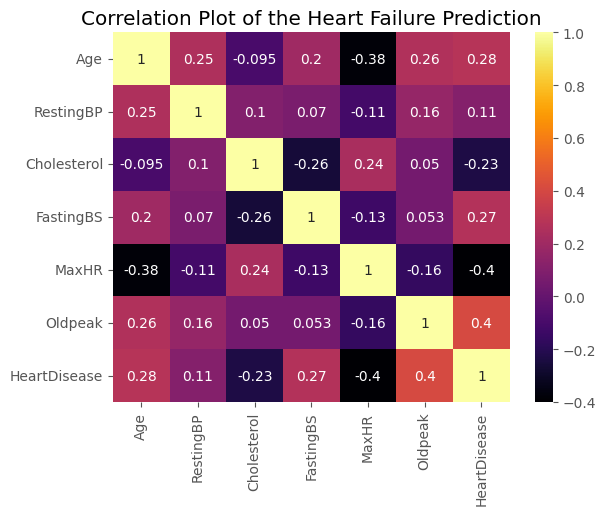

In [11]:
string_col = df_copy.select_dtypes("string").columns.to_list()
num_col = df_copy.columns.to_list()

for col in string_col:
    num_col.remove(col)

df_copy = df_copy[num_col]


sns.heatmap(df_copy.corr(), annot=True, cmap="inferno")
plt.title("Correlation Plot of the Heart Failure Prediction")
plt.show()

# 查看男性、女性患有心力衰竭症狀之分佈

In [12]:
fig=px.histogram(df, 
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="Distribution of Heart Diseases",
                 barmode="group")

fig.update_layout(
    width=600,  # 設定寬度
    height=400  # 你也可以設定高度（選擇性）
)


fig.show()


# 查看男、女性胸口疼痛類型之分佈

In [13]:
fig=px.histogram(df, 
                 x="ChestPainType",
                 color="Sex",
                 hover_data=df.columns,
                 title="Distribution of Heart Diseases",
                 barmode="group")

fig.update_layout(
    width=600,  # 設定寬度
    height=400  # 你也可以設定高度（選擇性）
)


fig.show()


# 離群值檢查

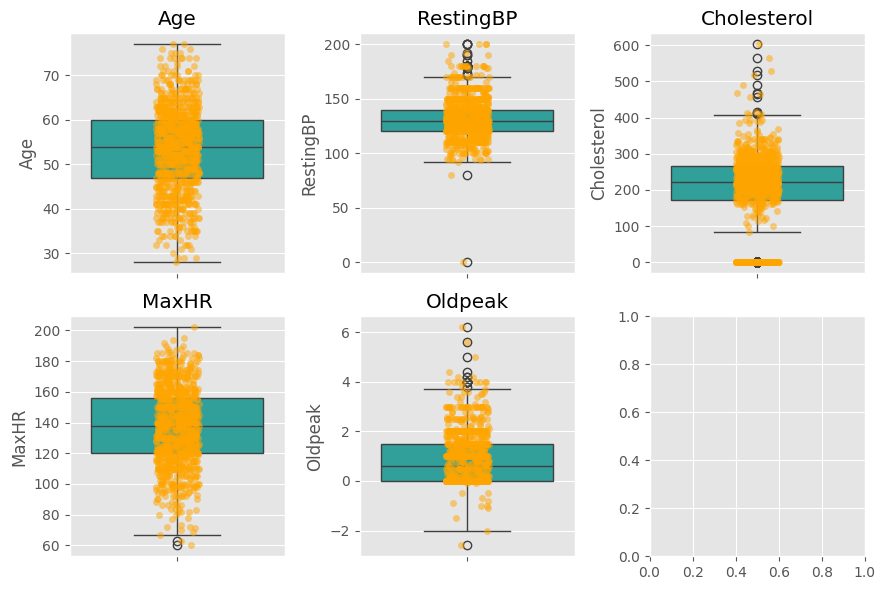

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(y=df_copy[feature], ax=axes[i], color="lightseagreen")
    sns.stripplot(y=df_copy[feature], ax=axes[i], color="orange", alpha=0.5)
    axes[i].set_title(feature)
    
plt.tight_layout()
plt.show()

# 查看變數之間的關係

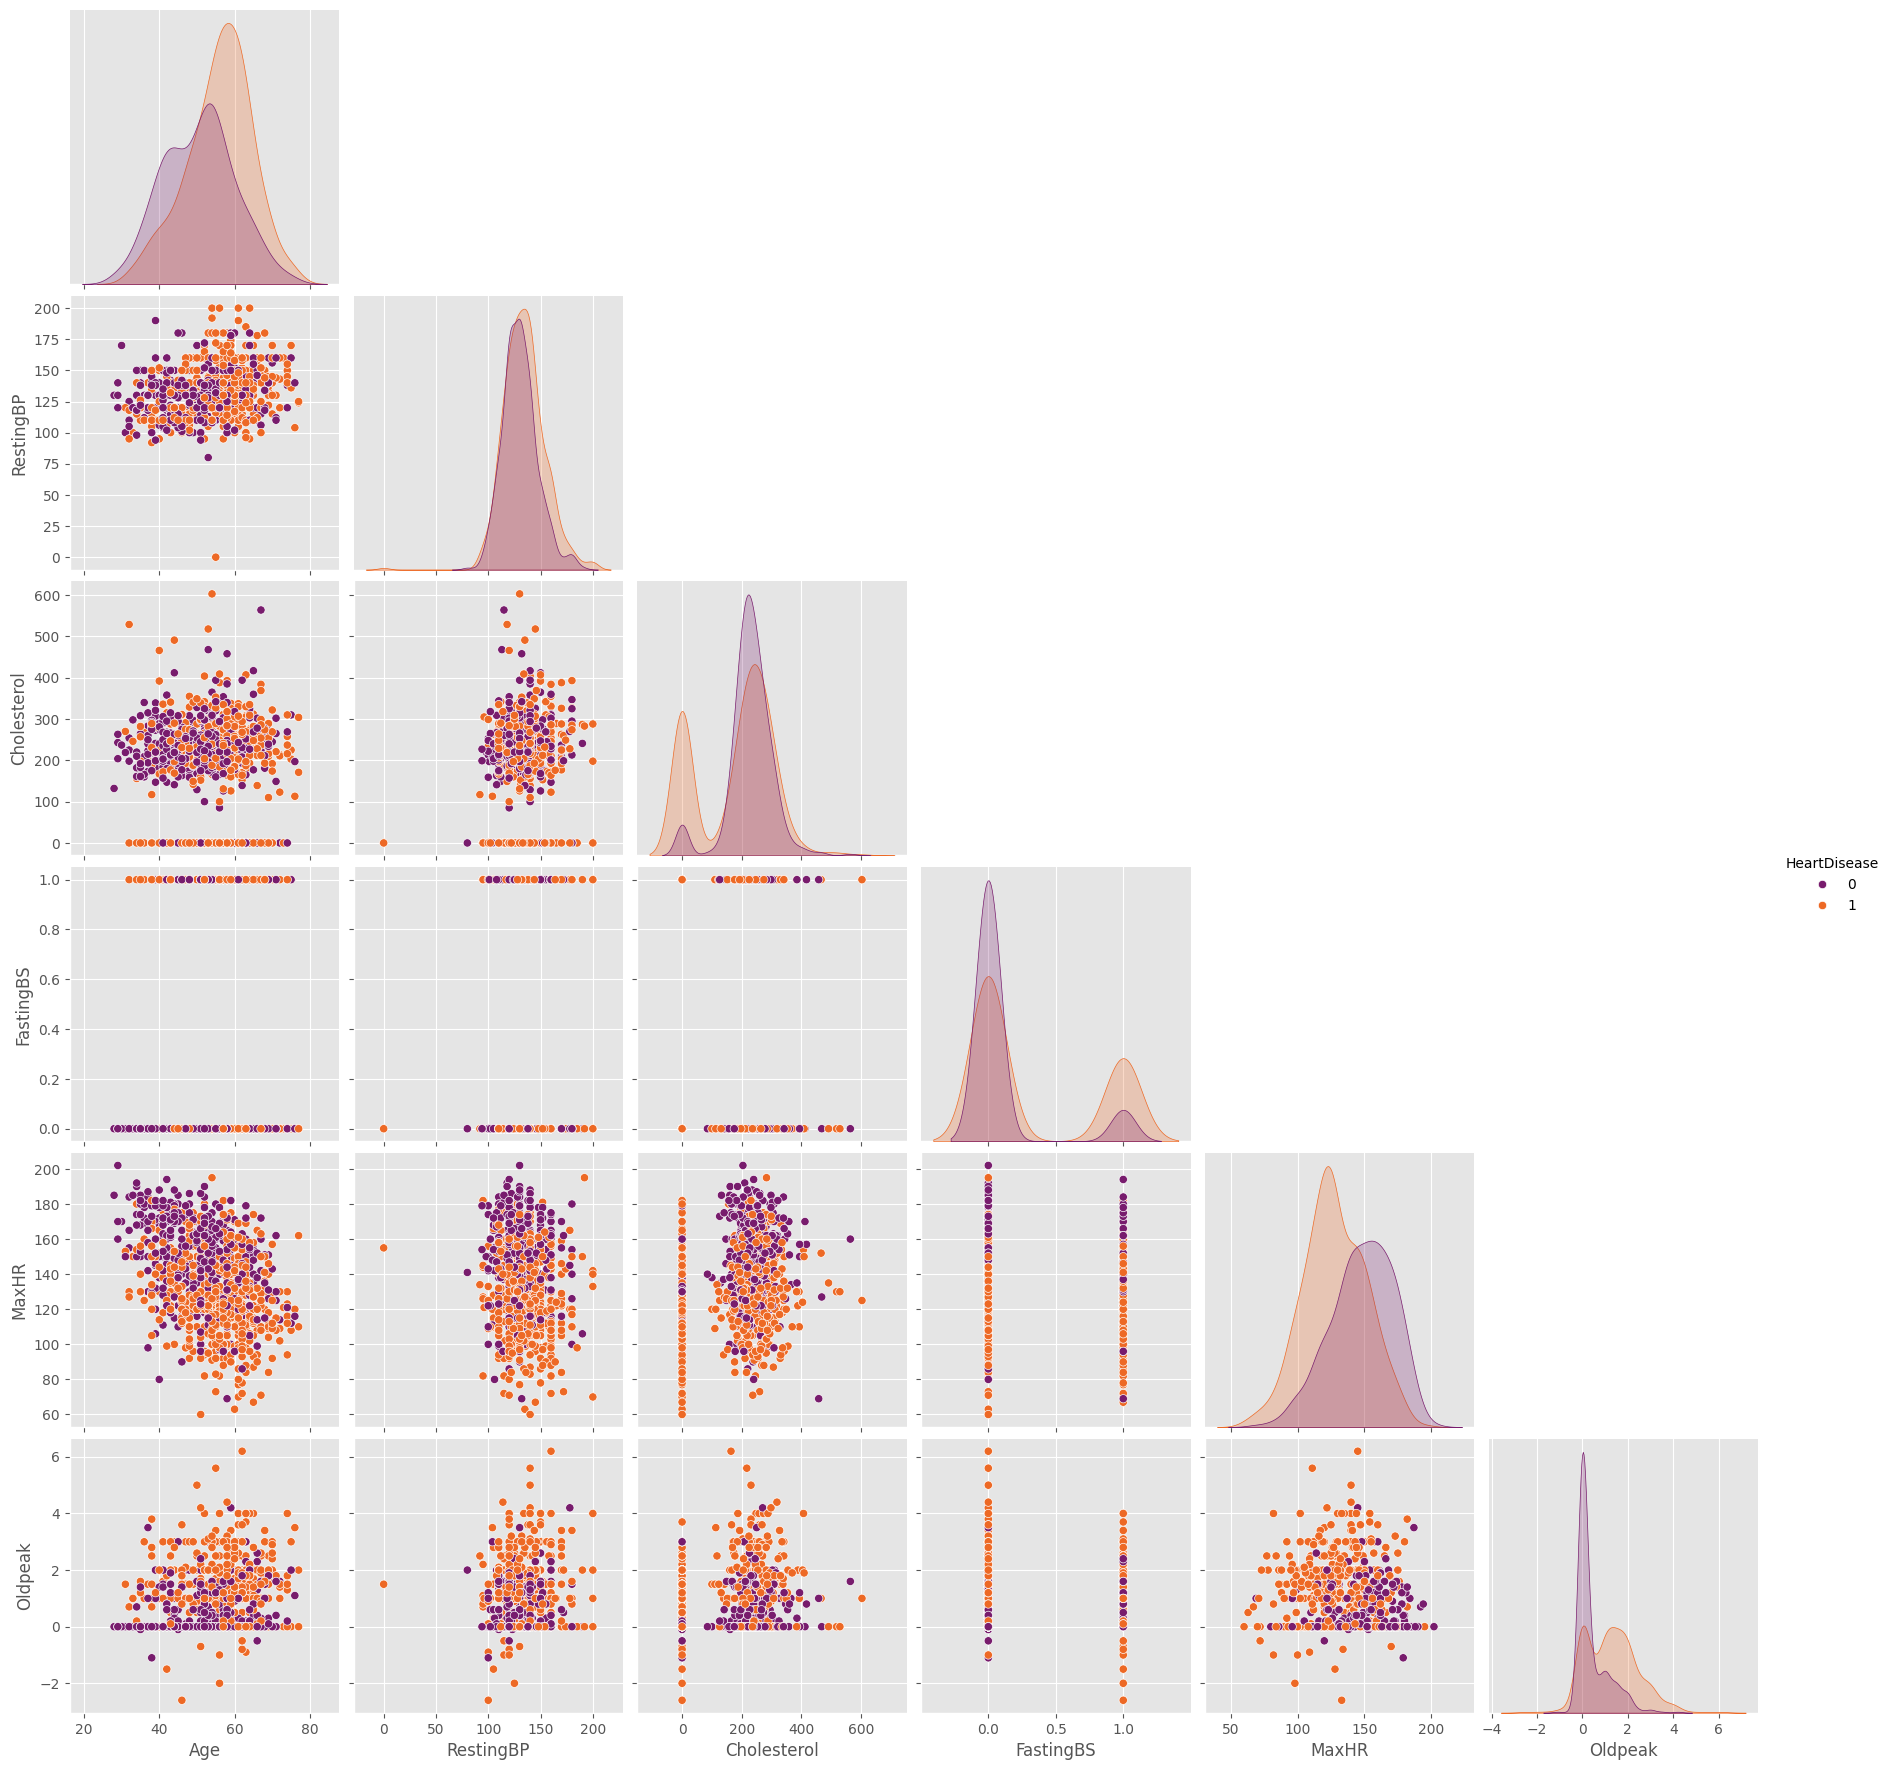

In [15]:
sns.pairplot(df_copy, hue = "HeartDisease", palette = "inferno", corner = True, height = 3, aspect = 1)
plt.show()

# 特徵工程
# 資料預處理

# 檢查Null Value

In [16]:
df.isnull().sum()


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# 處理異常值

Age
最小值：27.5 最大值:79.5 均值:54.0

RestingBP
最小值：90.0 最大值:170.0 均值:130.0

Cholesterol
最小值：32.625 最大值:407.625 均值:223.0

MaxHR
最小值：66.0 最大值:210.0 均值:138.0

Oldpeak
最小值：-2.25 最大值:3.75 均值:0.6



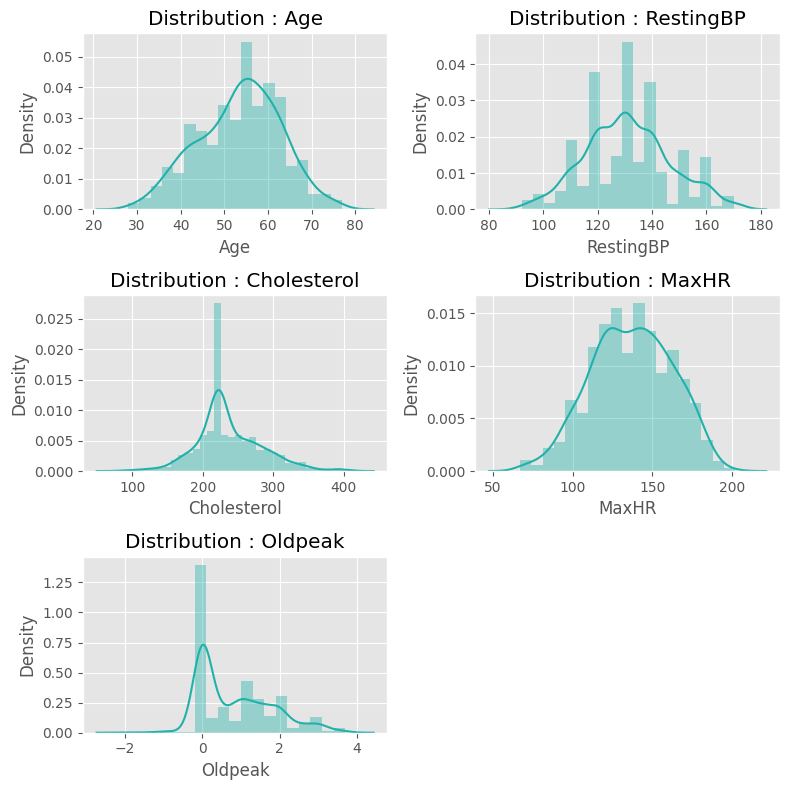

In [17]:
for feature in numerical_features:
    Q1 = df[feature].quantile(q=0.25)
    Q2 = df[feature].median()
    Q3 = df[feature].quantile(q=0.75)

    IQR = Q3-Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    print(f"{feature}\n最小值：{lower_bound} 最大值:{upper_bound} 均值:{Q2}\n")
    


    for idx in range(df.shape[0]):
        if df[feature].iloc[idx] > upper_bound or df[feature].iloc[idx] < lower_bound:
                
            df[feature].iloc[idx] = Q2
    

df.describe().T

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (8,8))
axes = axes.flatten()


for i in range(len(numerical_features)):
    sns.distplot(df[numerical_features[i]], ax = axes[i], color = "lightseagreen")
    title = "Distribution : " + numerical_features[i]
    axes[i].set_title(title)

axes[-1].axis('off')


plt.tight_layout()
plt.show()

# 特徵選擇
#### 使用卡方檢定來判斷類別型特徵是否對心臟病存在顯著的相關性

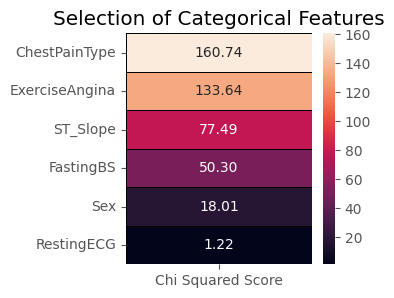

In [18]:
categorical_features_df = df[categorical_features].iloc[:,:-1]
target_df = pd.DataFrame(df.iloc[:,-1])

best_feature = SelectKBest(score_func = chi2, k = 'all')
fit = best_feature.fit(categorical_features_df, target_df)

featureScores = pd.DataFrame(data = fit.scores_,index = list(categorical_features_df.columns), columns = ["Chi Squared Score"])

plt.subplots(figsize = (3,3))
sns.heatmap(featureScores.sort_values(ascending = False, by = "Chi Squared Score"), annot = True, linewidth = 0.4, linecolor = 'black', fmt = '.2f')
plt.title("Selection of Categorical Features")
plt.show()



# 使用ANOVA檢定來判斷數值型特徵是否對心臟病存在顯著影響

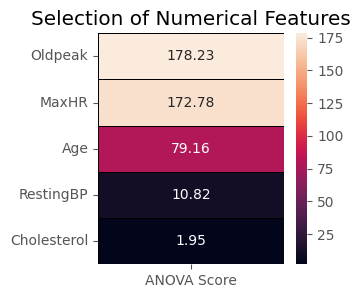

In [19]:
numerical_features_df = df[numerical_features]
target_df = pd.DataFrame(df.iloc[:,-1])


best_feature = SelectKBest(score_func = f_classif, k = 'all')
fit = best_feature.fit(numerical_features_df, target_df)

featureScores = pd.DataFrame(data = fit.scores_,index = list(numerical_features_df.columns), columns = ["ANOVA Score"])

plt.subplots(figsize = (3,3))
sns.heatmap(featureScores.sort_values(ascending = False, by = "ANOVA Score"), annot = True, linewidth = 0.4, linecolor = 'black', fmt = '.2f')
plt.title("Selection of Numerical Features")
plt.show()




# 特徵縮放(Feature Scaling)
#### 有些模型對於數值範圍較大的特徵相對敏感，導致其主導模型，
#### 進而造成模型性能下降或收斂速度變慢，所以要把資料集中不同特徵的數值範圍縮放到相同的尺度上。
####

#### 1. 標準化把數據轉換成均值為０，標準差為1的分佈，適用在當特徵具有不同尺度或單位時，或當數據具有高斯分佈時，其效果較佳。

#### 2. 正則化則是把數據縮放到特定範圍，通常是0~1之間。適用在數據範圍差異小，且希望將所有特徵縮放到一個固定區間時使用。

In [20]:
scalar = StandardScaler()

to_remove = ["RestingBP","Cholesterol"]

for val in to_remove:
    numerical_features.remove(val)

for feature in numerical_features:
    df[feature] = scalar.fit_transform(df[feature].values.reshape(-1,1))

# 模型預測結果
#### AUC 是 ROC 曲線下的面積，用來量化模型的區分能力。AUC 值範圍在 0 到 1 之間，越接近 1，表示模型越能區分正樣本和負樣本，AUC = 0.5 則意味著模型的表現和隨機猜測相似。

Cross Validation Score :  91.16%
ROC_AUC Score :  84.34%


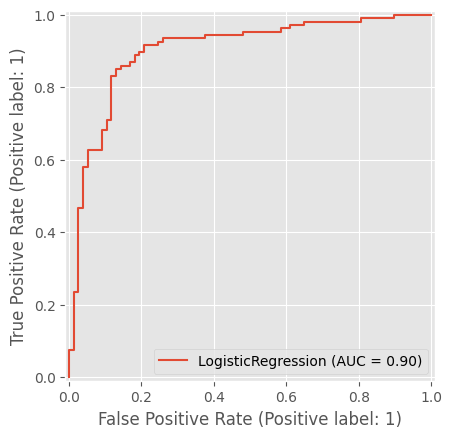

In [21]:
X = df.drop("HeartDisease", axis = 1).values
y = pd.DataFrame(df["HeartDisease"]).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=0,C=10,penalty = "l2")

model.fit(X_train, y_train)

prediction = model.predict(X_test)

cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(model,X_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
RocCurveDisplay.from_estimator(model, X_test, y_test)

# Confusion Matrix

              precision    recall  f1-score   support

           0       0.76      0.88      0.82        77
           1       0.91      0.80      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



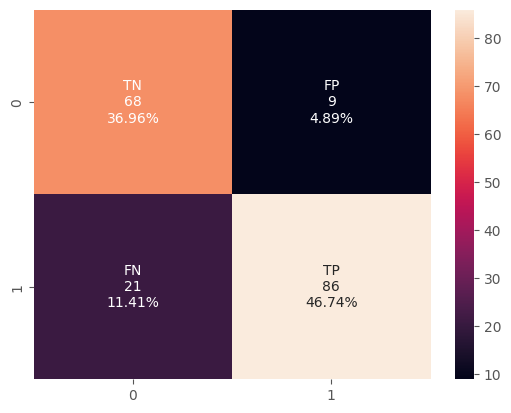

In [22]:
cm = confusion_matrix(y_test,model.predict(X_test))
names = ['TN','FP','FN','TP']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,fmt ='')

# Classification Report
print(classification_report(y_test,model.predict(X_test)))